# Segmentation
Segmentation describes the process of finding cells in an image. This can be done either on the nucleus or on whole cell level. Spatialproteomics provides wrappers for StarDist, mesmer and cellpose.

If you want to follow along with this tutorial, you can download the data [here](https://oc.embl.de/index.php/s/XzEa9po1tjiDzzJ).

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import spatialproteomics
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

In [3]:
# loading the input data
ds = xr.open_zarr("../../data/segmentation_example.zarr").pp[1000:1300, 1000:1300].pp.drop_layers(keep="_image")

In [4]:
# checking what the object initially looks like
ds

<xarray.Dataset> Size: 367kB
Dimensions:   (channels: 4, y: 301, x: 301)
Coordinates:
  * channels  (channels) <U11 176B 'DAPI' 'Na/K ATPase' 'CD68' 'CD11c'
  * x         (x) int64 2kB 1000 1001 1002 1003 1004 ... 1297 1298 1299 1300
  * y         (y) int64 2kB 1000 1001 1002 1003 1004 ... 1297 1298 1299 1300
Data variables:
    _image    (channels, y, x) uint8 362kB dask.array<chunksize=(4, 301, 301), meta=np.ndarray>

## Whole-Cell Segmentation with Cellpose

Cellpose can either perform segmentation on nuclei only or on whole cells, using a nuclear and a membrane marker. In this dataset, we have DAPI as a nuclear marker and Na/K ATPase as a membrane marker. In cellpose 4, the order of these does not matter. You can refer to the [cellpose documentation](https://cellpose.readthedocs.io/en/latest/settings.html) for more details to tweak the model.

In [5]:
# running the segmentation on the selected markers
ds_cellpose = ds.tl.cellpose(channel=["Na/K ATPase", "DAPI"])
ds_cellpose



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.4 
platform:       	linux 
python version: 	3.10.0 
torch version:  	2.7.0+cu126! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




Neither TORCH CUDA nor MPS version not installed/working.
>>>> using CPU
>>>> using CPU
>>>> loading model /home/meyerben/.cellpose/models/cpsam


<xarray.Dataset> Size: 555kB
Dimensions:        (channels: 4, y: 301, x: 301, cells: 282, features: 2)
Coordinates:
  * channels       (channels) <U11 176B 'DAPI' 'Na/K ATPase' 'CD68' 'CD11c'
  * x              (x) int64 2kB 1000 1001 1002 1003 ... 1297 1298 1299 1300
  * y              (y) int64 2kB 1000 1001 1002 1003 ... 1297 1298 1299 1300
  * cells          (cells) int64 2kB 1 2 3 4 5 6 7 ... 277 278 279 280 281 282
  * features       (features) <U10 80B 'centroid-0' 'centroid-1'
Data variables:
    _image         (channels, y, x) uint8 362kB dask.array<chunksize=(4, 301, 301), meta=np.ndarray>
    _segmentation  (y, x) uint16 181kB 0 0 0 0 0 0 0 ... 274 274 274 274 274 0
    _obs           (cells, features) float64 5kB 1.009e+03 ... 1.004e+03

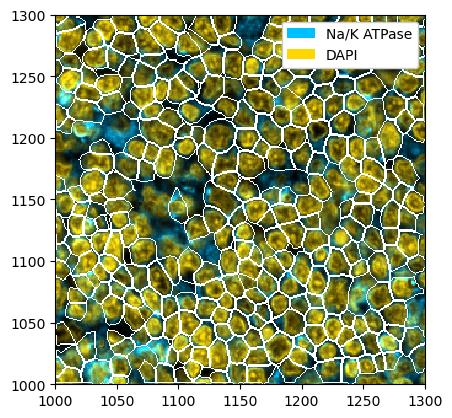

In [6]:
# for plotting, we subselect the two markers from before, but you could also show the other markers
_ = ds_cellpose.pp[["Na/K ATPase", "DAPI"]].pl.colorize(["deepskyblue", "gold"]).pl.show(render_segmentation=True)

## Whole-Cell Segmentation with Mesmer

You can also do the same thing with mesmer. Note however that mesmer expects the channels to be in the order `[nuclear, membrane]`.

2025-05-27 07:51:35.308013: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /g/huber/users/meyerben/.conda/envs/tmp_env_3/lib/python3.10/site-packages/cv2/../../lib64:
2025-05-27 07:51:35.308044: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Checking for cached data
Checking MultiplexSegmentation-9.tar.gz against provided file_hash...
MultiplexSegmentation-9.tar.gz with hash a1dfbce2594f927b9112f23a0a1739e0 already available.
Extracting /home/meyerben/.deepcell/models/MultiplexSegmentation-9.tar.gz
Successfully extracted /home/meyerben/.deepcell/models/MultiplexSegmentation-9.tar.gz into /home/meyerben/.deepcell/models
2025-05-27 07:51:40.668279: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic li

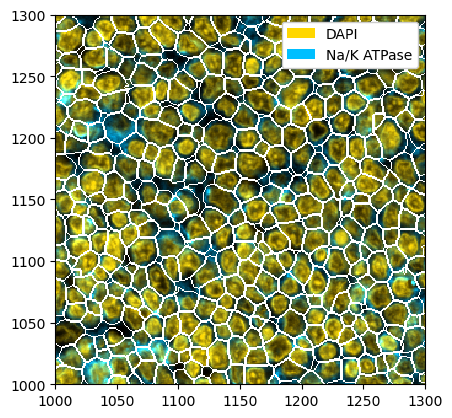

In [7]:
# running mesmer
ds_mesmer = ds.tl.mesmer(channel=["DAPI", "Na/K ATPase"])
# plotting the result
_ = ds_mesmer.pp[["DAPI", "Na/K ATPase"]].pl.colorize(["gold", "deepskyblue"]).pl.show(render_segmentation=True)

## Nuclear Segmentation with StarDist

Sometimes, you may not have a membrane stain available. In that case, you can perform nuclear segmentation. This is possible with cellpose (simply call `tl.cellpose(channel='DAPI')`) and StarDist.
The following shows and example of how StarDist performs on such a task.

In [8]:
# running stardist
ds_stardist = ds.tl.stardist(channel="DAPI")

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


100%|██████████| 144/144 [00:08<00:00, 16.26it/s]


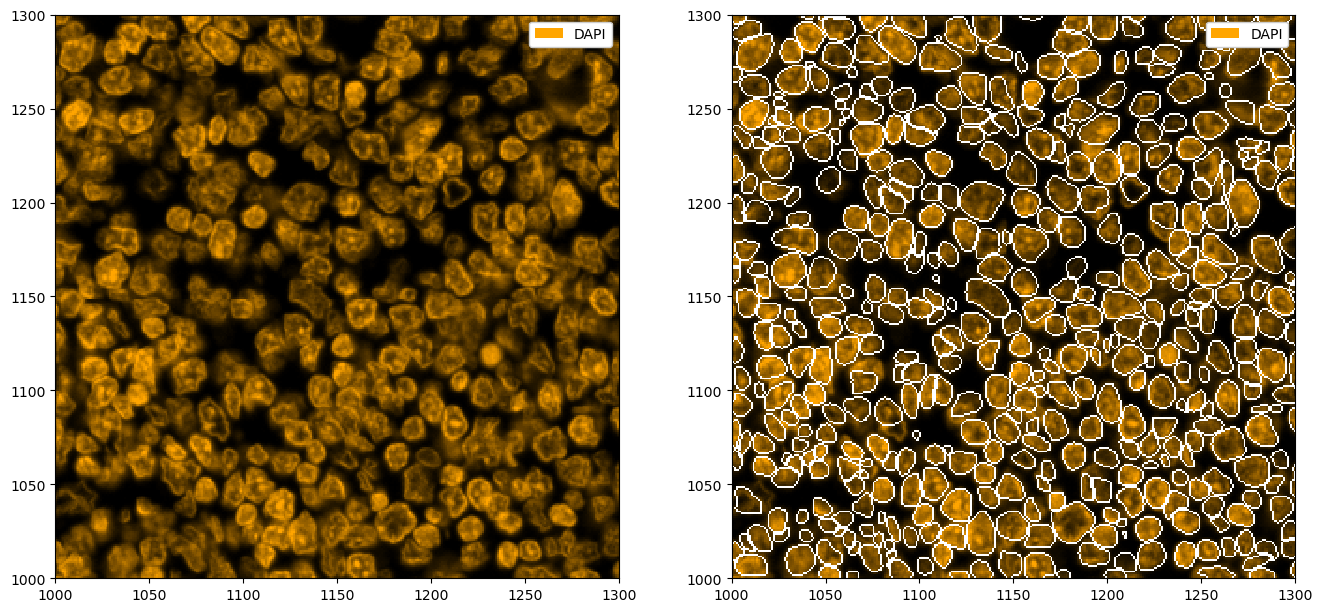

In [9]:
# plotting the segmentation
fix, ax = plt.subplots(1, 2, figsize=(16, 8))
_ = ds_stardist.pp["DAPI"].pl.colorize("orange").pl.show(ax=ax[0])
_ = ds_stardist.pp["DAPI"].pl.colorize("orange").pl.show(render_segmentation=True, ax=ax[1])

You might have noticed that StarDist tends to segment a lot of small cells. Let's look at the distribution of cell sizes, and then remove all nuclei under a certain size.

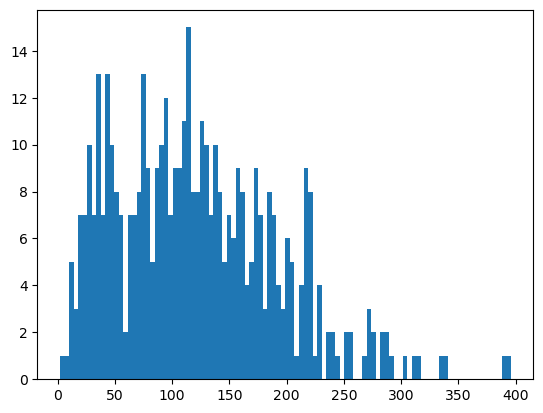

In [10]:
# getting a histogram of the areas
_ = plt.hist(ds_stardist.pp.add_observations("area").pp.get_layer_as_df()["area"], bins=100)

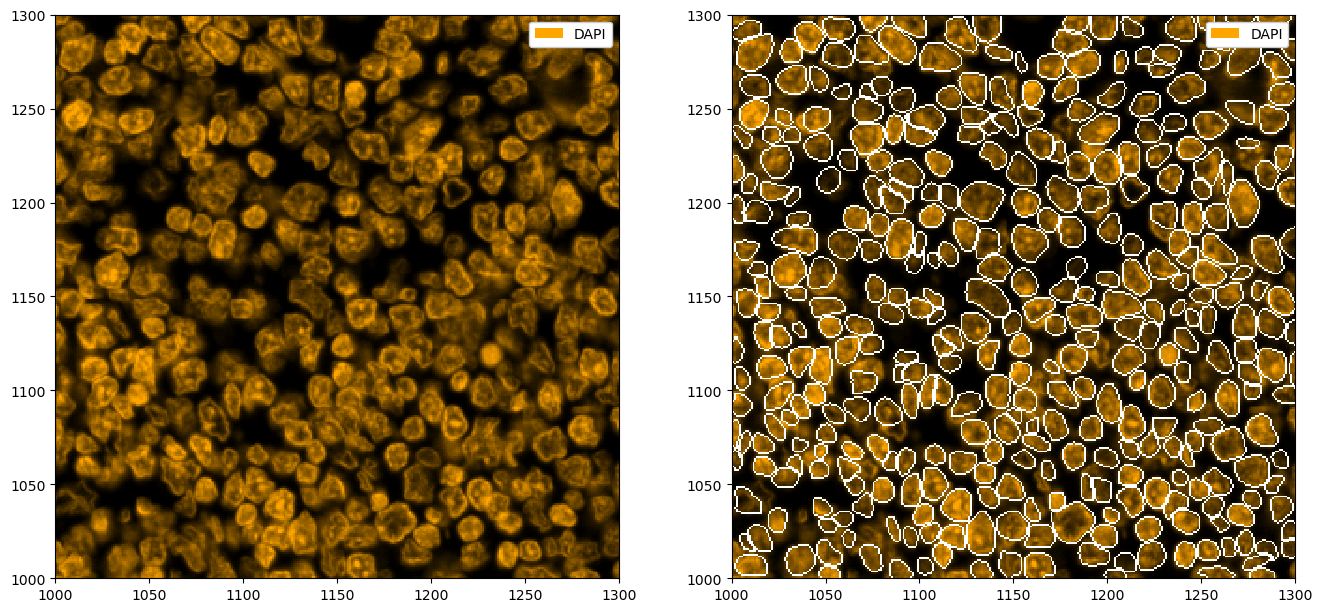

In [11]:
# removing cells which have an area below 50 pixels
ds_stardist = ds_stardist.pp.add_observations("area").pp.filter_by_obs("area", lambda x: x > 50)

# plotting the segmentation
fix, ax = plt.subplots(1, 2, figsize=(16, 8))
_ = ds_stardist.pp["DAPI"].pl.colorize("orange").pl.show(ax=ax[0])
_ = ds_stardist.pp["DAPI"].pl.colorize("orange").pl.show(render_segmentation=True, ax=ax[1])

To try to capture full cells, we can now grow the segmentation masks, e. g. by two pixels into each direction. If two masks collide, the masks will stop growing into that direction.

In [12]:
ds_stardist_grown = ds_stardist.pp.grow_cells(2)

Mask growing requires recalculation of the observations. All features other than the centroids will be removed and should be recalculated with pp.add_observations().


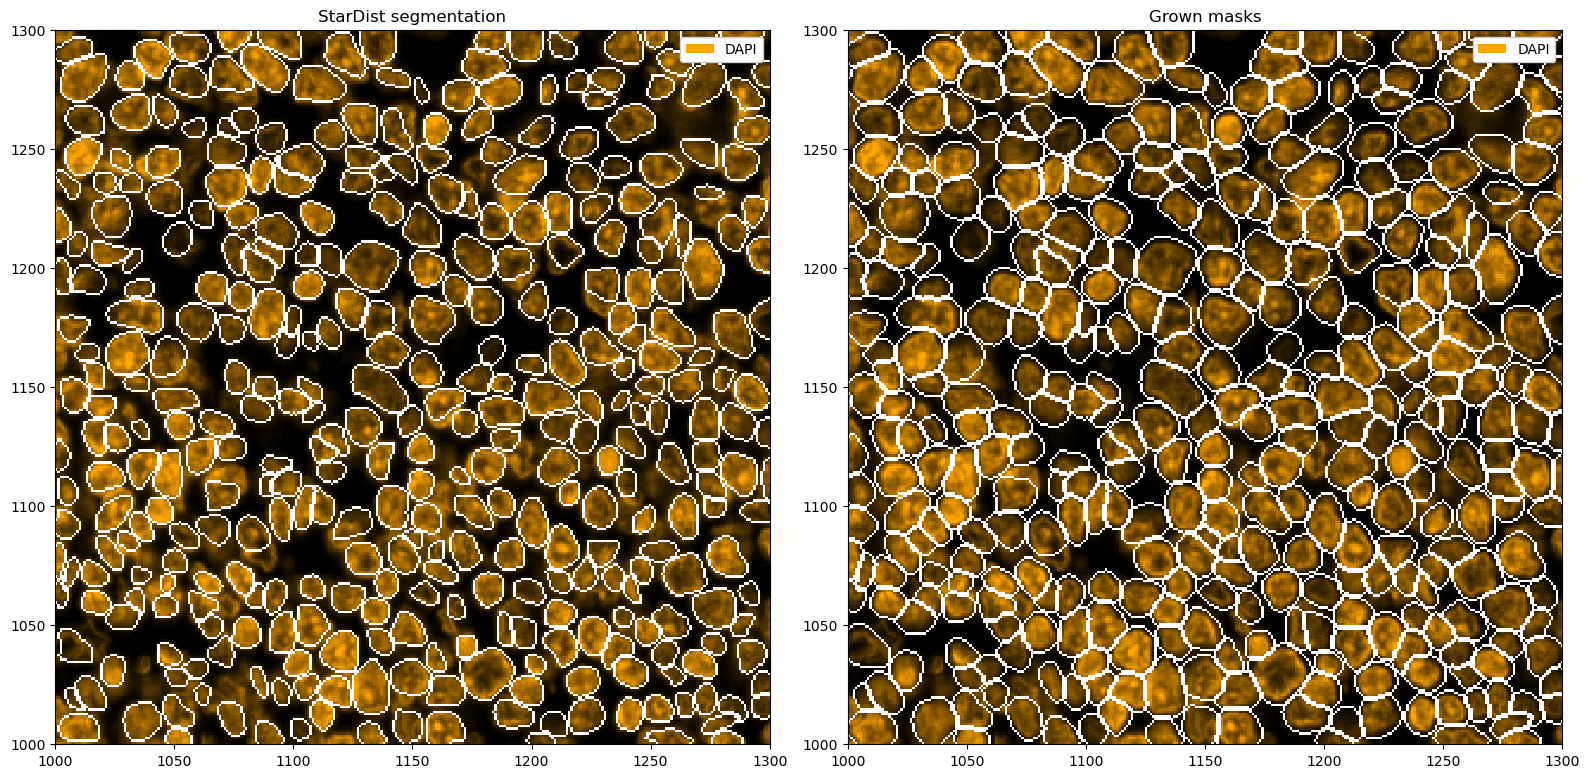

In [13]:
# plotting the segmentation
fix, ax = plt.subplots(1, 2, figsize=(16, 8))
_ = ds_stardist.pp["DAPI"].pl.colorize("orange").pl.show(render_segmentation=True, ax=ax[0])
_ = ds_stardist_grown.pp["DAPI"].pl.colorize("orange").pl.show(render_segmentation=True, ax=ax[1])
ax[0].set_title("StarDist segmentation")
ax[1].set_title("Grown masks")
plt.tight_layout()

## Segmenting Multiple Channels with Cellpose

Next to predicting nuclei or whole cells using a universal membrane marker, you can also use cellpose to try to predict other cell types. In the following, we will see how we can use cellpose to segment three different channels independently and then merge the segmentation masks into one mask. There are some hyperparameters in cellpose which can help the prediction.

In [14]:
# segmenting on DAPI, CD11c (dendritic cells) and CD68 (macrophages)
# note that when merging the masks later, the order matters (channels take precedence by position in the subsetting)
# so you should have your largest cells first, and then go down by expected size

# we use the channel_settings argument here to tell cellpose that it should perform an independent segmentation for each of our markers
# without this argument, cellpose-sam would try to segment the cells based on all three markers combined
ds_cellpose = ds.pp[["CD11c", "CD68", "DAPI"]].tl.cellpose(key_added="_cellpose_segmentation", channel_settings=[0, 0])

Neither TORCH CUDA nor MPS version not installed/working.
>>>> using CPU
>>>> using CPU
>>>> loading model /home/meyerben/.cellpose/models/cpsam
Performing independent segmentation on all markers. If you want to perform joint segmentation, please set the channel_settings argument appropriately.


In [15]:
ds_cellpose

<xarray.Dataset> Size: 820kB
Dimensions:                 (channels: 3, y: 301, x: 301)
Coordinates:
  * channels                (channels) <U11 132B 'CD11c' 'CD68' 'DAPI'
  * x                       (x) int64 2kB 1000 1001 1002 1003 ... 1298 1299 1300
  * y                       (y) int64 2kB 1000 1001 1002 1003 ... 1298 1299 1300
Data variables:
    _image                  (channels, y, x) uint8 272kB dask.array<chunksize=(3, 301, 301), meta=np.ndarray>
    _cellpose_segmentation  (channels, y, x) uint16 544kB 0 0 0 ... 309 309 309

In [16]:
# merging the segmentation masks into a single segmentation
# the threshold value tells you how much of a mask need to overlap for the less important one to be removed
ds_cellpose_merged = ds_cellpose.pp.merge_segmentation(
    "_cellpose_segmentation", labels=["Dendritic Cell", "Macrophage", "Lymphocyte"], threshold=0.8
)

In [17]:
ds_cellpose_merged

<xarray.Dataset> Size: 1MB
Dimensions:                 (channels: 3, y: 301, x: 301)
Coordinates:
  * channels                (channels) <U11 132B 'CD11c' 'CD68' 'DAPI'
  * x                       (x) int64 2kB 1000 1001 1002 1003 ... 1298 1299 1300
  * y                       (y) int64 2kB 1000 1001 1002 1003 ... 1298 1299 1300
Data variables:
    _image                  (channels, y, x) uint8 272kB dask.array<chunksize=(3, 301, 301), meta=np.ndarray>
    _cellpose_segmentation  (channels, y, x) uint16 544kB 0 0 0 ... 309 309 309
    _merged_segmentation    (y, x) uint16 181kB 0 11 11 11 ... 301 301 301 301

In [18]:
# adding the merged segmentation as the main segmentation in the object
# this is done so that we can visualize the result with pl.show(render_segmentation=True), without needing to specify which segmentation we want to show
ds_cellpose_merged = ds_cellpose_merged.pp.add_segmentation("_merged_segmentation")

In [19]:
ds_cellpose_merged

<xarray.Dataset> Size: 1MB
Dimensions:                 (labels: 3, la_props: 2, channels: 3, x: 301,
                             y: 301, cells: 306, features: 3)
Coordinates:
  * labels                  (labels) int64 24B 1 2 3
  * la_props                (la_props) <U6 48B '_color' '_name'
  * channels                (channels) <U11 132B 'CD11c' 'CD68' 'DAPI'
  * x                       (x) int64 2kB 1000 1001 1002 1003 ... 1298 1299 1300
  * y                       (y) int64 2kB 1000 1001 1002 1003 ... 1298 1299 1300
  * cells                   (cells) int64 2kB 1 2 3 4 5 ... 302 303 304 305 306
  * features                (features) <U10 120B '_labels' ... 'centroid-1'
Data variables:
    _la_properties          (labels, la_props) object 48B '#A3C8C9' ... 'Macr...
    _image                  (channels, y, x) uint8 272kB dask.array<chunksize=(3, 301, 301), meta=np.ndarray>
    _cellpose_segmentation  (channels, y, x) uint16 544kB 0 0 0 ... 309 309 309
    _merged_segmentation    (y, x) uint16 181kB 0 11 11 11 ... 301 301 301 301
    _obs                    (cells, features) float64 7kB 1.0 ... 1.004e+03
    _segmentation           (y, x) uint16 181kB 0 11 11 11 ... 301 301 301 301

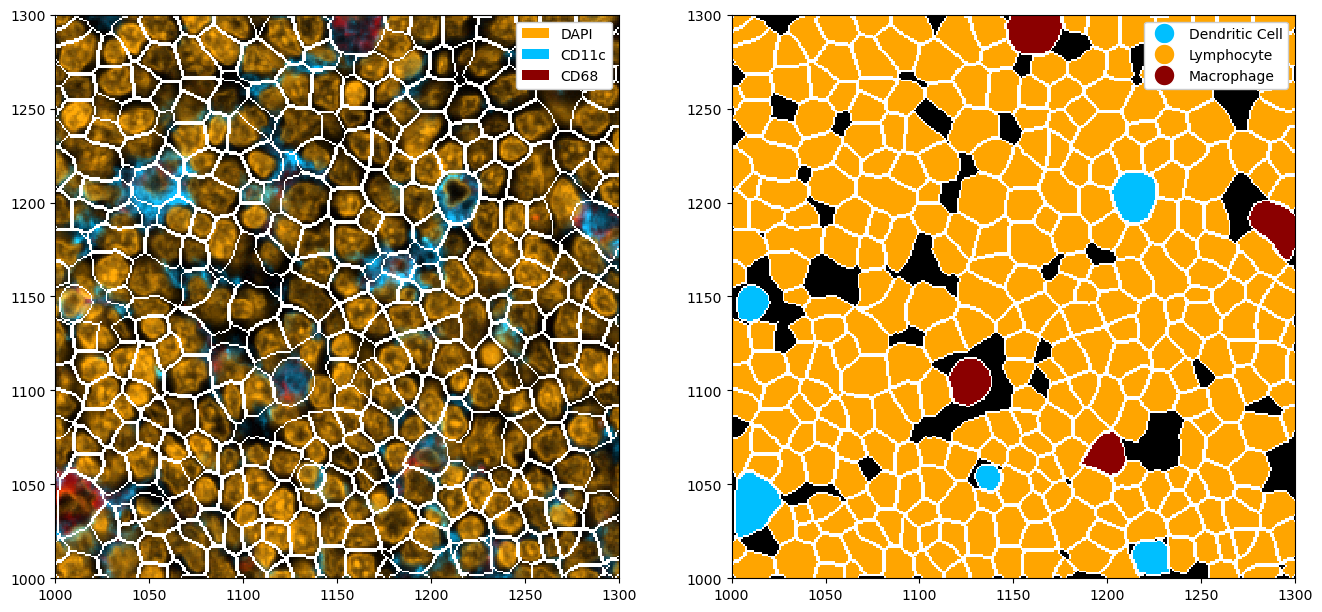

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# adding colors to match the channel colors
colors = ["orange", "deepskyblue", "darkred"]
ds_cellpose_merged = ds_cellpose_merged.la.set_label_colors(["Lymphocyte", "Dendritic Cell", "Macrophage"], colors)

# merged masks
_ = (
    ds_cellpose_merged.pp[["DAPI", "CD11c", "CD68"]]
    .pl.colorize(colors=colors)
    .pl.show(render_segmentation=True, ax=ax[0])
)
_ = ds_cellpose_merged.pl.show(
    render_image=False, render_segmentation=True, render_labels=True, legend_label=True, ax=ax[1]
)

## Fine-Tuning Cellpose
Cellpose often benefits from fine-tuning, which is detailed in their [documentation](https://cellpose.readthedocs.io/en/latest/gui.html#training-your-own-cellpose-model). You can load fine-tuned cellpose models into spatialproteomics by using `ds.tl.cellpose(channel="your_marker", pretrained_model=model_path)`

## Merging Segmentation Masks from Different Layers

In the previous section, we looked at how to merge masks from a single layer. But what do we do if we have multiple segmentations in different layers?

Let us consider an example. Mesmer always requires two channels to segment an image (a nuclear and a membrane stain). We can run mesmer on our membrane stain, and then run cellpose on the macrophages and dendritic cells. However, now our segmentation masks are stored in different layers. The good thing is, we can combine them just as easily by using `pp.merge_segmentation()`.

In [21]:
# running mesmer and cellpose to obtain a bunch of different segmentation masks
# these are stored in the layers dapi_seg, macro_seg, and dendritic_seg
ds_mesmer = (
    ds.tl.mesmer(channel=["DAPI", "Na/K ATPase"], key_added="dapi_seg")
    .tl.cellpose(channel="CD68", key_added="macro_seg")
    .tl.cellpose(channel="CD11c", key_added="dendritic_seg")
)
ds_mesmer

Checking for cached data
Checking MultiplexSegmentation-9.tar.gz against provided file_hash...
MultiplexSegmentation-9.tar.gz with hash a1dfbce2594f927b9112f23a0a1739e0 already available.
Extracting /home/meyerben/.deepcell/models/MultiplexSegmentation-9.tar.gz
Successfully extracted /home/meyerben/.deepcell/models/MultiplexSegmentation-9.tar.gz into /home/meyerben/.deepcell/models
No training configuration found in save file, so the model was *not* compiled. Compile it manually.
Converting image dtype to float
Neither TORCH CUDA nor MPS version not installed/working.
>>>> using CPU
>>>> using CPU
>>>> loading model /home/meyerben/.cellpose/models/cpsam
Neither TORCH CUDA nor MPS version not installed/working.
>>>> using CPU
>>>> using CPU
>>>> loading model /home/meyerben/.cellpose/models/cpsam


<xarray.Dataset> Size: 1MB
Dimensions:        (channels: 4, y: 301, x: 301)
Coordinates:
  * channels       (channels) <U11 176B 'DAPI' 'Na/K ATPase' 'CD68' 'CD11c'
  * x              (x) int64 2kB 1000 1001 1002 1003 ... 1297 1298 1299 1300
  * y              (y) int64 2kB 1000 1001 1002 1003 ... 1297 1298 1299 1300
Data variables:
    _image         (channels, y, x) uint8 362kB dask.array<chunksize=(4, 301, 301), meta=np.ndarray>
    dapi_seg       (y, x) int64 725kB 11 11 11 11 11 11 ... 344 344 344 344 344
    macro_seg      (y, x) uint16 181kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    dendritic_seg  (y, x) uint16 181kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0

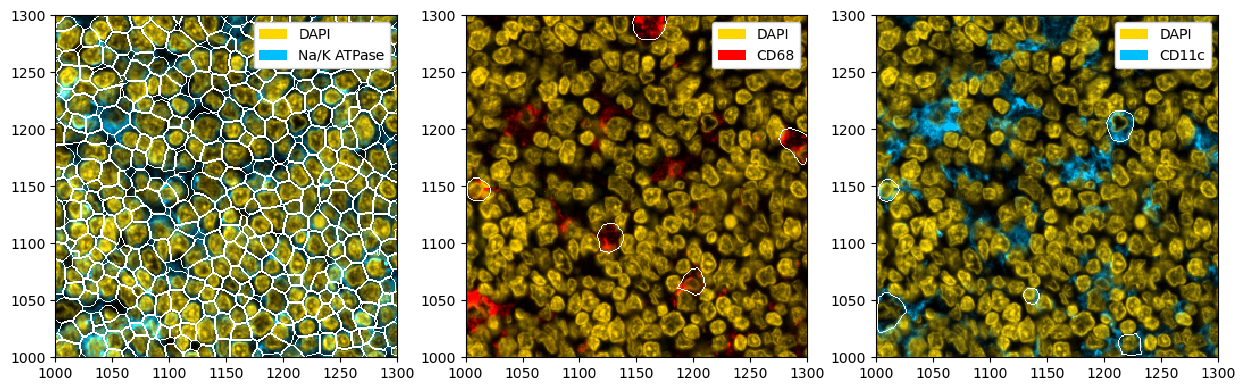

In [22]:
# plotting the individual masks
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
_ = (
    ds_mesmer.pp[["DAPI", "Na/K ATPase"]]
    .pl.colorize(["gold", "deepskyblue"])
    .pl.show(render_segmentation=True, segmentation_kwargs={"layer_key": "dapi_seg"}, ax=ax[0])
)

_ = (
    ds_mesmer.pp[["DAPI", "CD68"]]
    .pl.colorize(["gold", "red"])
    .pl.show(render_segmentation=True, segmentation_kwargs={"layer_key": "macro_seg"}, ax=ax[1])
)

_ = (
    ds_mesmer.pp[["DAPI", "CD11c"]]
    .pl.colorize(["gold", "deepskyblue"])
    .pl.show(render_segmentation=True, segmentation_kwargs={"layer_key": "dendritic_seg"}, ax=ax[2])
)

In [23]:
# merging the segmentation masks and making the merged segmentation the default one
ds_mesmer = ds_mesmer.pp.merge_segmentation(
    layer_key=["dendritic_seg", "macro_seg", "dapi_seg"],
    labels=["Dendritic Cell", "Macrophage", "Lymphocyte"],
    threshold=0.8,
).pp.add_segmentation("_merged_segmentation")

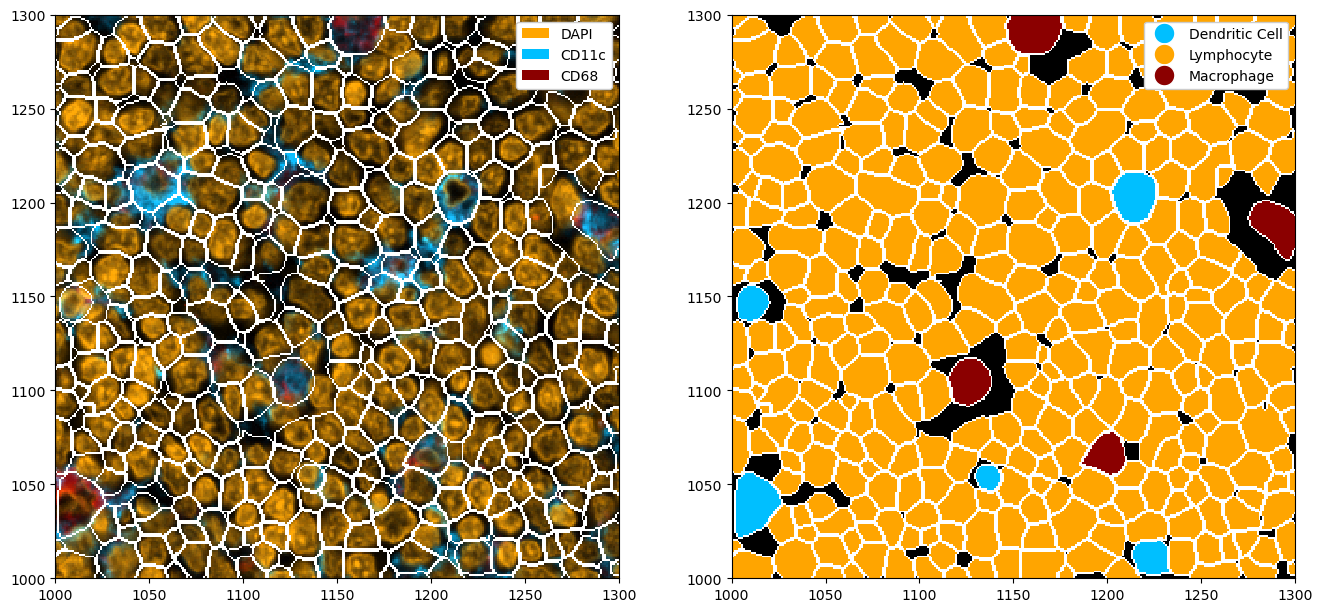

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# adding colors to match the channel colors
colors = ["orange", "deepskyblue", "darkred"]
ds_mesmer = ds_mesmer.la.set_label_colors(["Lymphocyte", "Dendritic Cell", "Macrophage"], colors)

# merged masks
_ = ds_mesmer.pp[["DAPI", "CD11c", "CD68"]].pl.colorize(colors=colors).pl.show(render_segmentation=True, ax=ax[0])
_ = ds_mesmer.pl.show(render_image=False, render_segmentation=True, render_labels=True, legend_label=True, ax=ax[1])